# First Simulation

In [98]:
import numpy as np
np.random.seed(42)

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_context('talk')

import copy

from scipy.constants import c, e, m_p

import PyHEADTAIL

#### Particle Parameters

In [99]:
p0 = 450e9 * e/c # Momentum
gamma = np.sqrt((p0/(m_p*c))**2 + 1)
beta = np.sqrt(1 - gamma**-2)

C = 26658.883 # Circumference
R = C/(2*np.pi) # Radius

alpha = 3.225e-4 # Momentum compaction factor, used in the longitudinal focusing calculations.
# Quantifies how the momentum of the particle changes as they travel around the accelerator
Q_x = 59.31 # Horizontal tune
Q_y = 64.28 # Vertical tune

eta = alpha - gamma**-2 # Slippage factor
h1 = 35640 # RF harmonic number
V1 = 8e6 # RF voltage
dp = 0 * e/c * C/(beta*c) # Momentum deviation
Q_s = 2e-3 # Longitudinal tune

#### Transverse and Longitudinal Particle Tracking

In [100]:
from PyHEADTAIL.trackers.transverse_tracking import TransverseMap
from PyHEADTAIL.trackers.longitudinal_tracking import RFSystems, LinearMap

n_segments = 1 # Number of segments/slices Each segment represents a portion of the bunch along the longitudinal direction.
# We separate into more segments when different segments of the bunch have different properties.

# Longitudinal positions of the segments along the circumference, for 1 segment it is 0 and C.
s = np.arange(n_segments+1) * C/(n_segments)

# Initialise the transverse map with one element (a zero) per segment.
alpha_x = 0.*s
alpha_y = 0.*s

# Represent the beta functions (transverse focussing strength) for each longitudinal segment.
beta_x = np.ones(n_segments+1) * R/Q_x # Note it is Radius/Tune
beta_y = np.ones(n_segments+1) * R/Q_y

# Create the transverse map object, which sets up the transverse beam optics for given longitudinal segments
trans_map = TransverseMap(s=[0, C],
    alpha_x=alpha_x, beta_x=beta_x, D_x=alpha_x, # D_x is the dispersion function
    alpha_y=alpha_y, beta_y=beta_y, D_y=alpha_y,
    accQ_x=Q_x, accQ_y=Q_y) # accQ_x and accQ_y are the transverse tunes

# Create LinearMap instance to represent longitudinal motion in the synchotron
long_map = LinearMap([alpha], C, Q_s) # It takes [alpha] which is a list containing the momentum compaction factor
#(may have different alpha for different segments)

# RFSystems object to represent the RF system in the synchrotron to accelerate particles
# RFSystems(
#     circumference=C,
#     harmonic_list=h, voltage_list=V, phi_offset_list=dphi, alpha_array=[alpha],
#     gamma_reference=gamma, p_increment=dp, mass=m_p, charge=e)

#### Bunch Creation

In [101]:
from PyHEADTAIL.trackers.rf_bucket import RFBucket
from PyHEADTAIL.particles.generators import ParticleGenerator, StationaryExponential, generate_Gaussian6DTwiss
from PyHEADTAIL.particles.generators import gaussian2D, longitudinal_linear_matcher, RF_bucket_distribution

# Set beam distribution parameters
epsn_x = 3.75e-6 # Normalised horizontal emittance
epsn_y = 3.75e-6 # Normalised vertical emittance
sigma_z = 0.07 # Standard deviation of the longitudinal bunch distribution (bunch length)
eps_geo_z = sigma_z * e/(4*np.pi*p0) # Normalised longitudinal emittance
# This quantifies the spread in momentum-space in the longitudinal direction

# bunch = ParticleGenerator(
#     macroparticlenumber=1e5, intensity=1e11,
#     charge=e, mass=m_p, gamma=gamma,
#     circumference=C,
#     distribution_x=gaussian2D(epsn_x), alpha_x=0, beta_x=beta_x[0],
#     distribution_y=gaussian2D(epsn_y), alpha_y=0, beta_y=beta_y[0],
#     distribution_z=gaussian2D(eps_geo_z), Qs=0.01, eta=eta).generate()
#     distribution_z=RF_bucket_distribution(rfbucket, sigma_z=0.23)).generate()

# Calculate the beta function (transverse focussing strength) for the longitudinal bunch distribution
beta_z = eta*R/Q_s
# Calculate the normalised longitudinal emittance, a measure of the spread in momentum-space in the longitudinal direction
epsn_z = 4*np.pi * sigma_z**2 * p0/(beta_z*e)

# Generate the bunch using the Twiss parameters for each plane
bunch = generate_Gaussian6DTwiss(
    macroparticlenumber=int(1e5), intensity=1e11,
    charge=e, gamma=gamma, mass=m_p, circumference=C,
    alpha_x=alpha_x[0], beta_x=beta_x[0], epsn_x=epsn_x,
    alpha_y=alpha_y[0], beta_y=beta_y[0], epsn_y=epsn_y,
    beta_z=beta_z, epsn_z=epsn_z)
    # print ('bunch sigma_z=' + bunch.sigma_z())

# Create a copy of bunch to use later
bunch_init = copy.copy(bunch)

#### Twiss Parameter Recap

alpha (α): The alpha parameter represents the rate of change of the particle displacement with respect to the angle (slopes) in the transverse plane. It quantifies the transverse tilt or angle of the beam. A positive value of alpha means that the beam converges (focuses) in the transverse direction, while a negative value means it diverges (defocuses).

beta (β): The beta parameter characterizes the transverse beam size. It describes how the transverse size of the beam changes with respect to the angle. A smaller value of beta corresponds to a tighter beam focus, while a larger value indicates a broader beam.

gamma (γ): The gamma parameter represents the rate of change of the angle with respect to the displacement in the transverse plane. It quantifies the curvature of the beam. A positive value of gamma means that the beam is curved in the direction of the beam axis, while a negative value means it is curved away from the beam axis.

emittance (ε): The emittance is a measure of the spread of particles in phase space. It is related to the volume in the transverse plane that contains most of the particles' positions and momenta. A smaller emittance corresponds to a tighter bunch of particles, while a larger emittance indicates a more spread-out bunch.

#### Transverse and Longitudinal Particle Tracking

In [102]:
# Create a list of all the elements in the trans_map object
# Each element is a transverse map describing the transverse beam optics at a specific longitudinal position.
one_turn_map = [m for m in trans_map] + [long_map]

In [103]:
#Enable Interaction Plotting and create a figure with 3 subplots
plt.ion()
fig, axes = plt.subplots(3, figsize=(16, 10))

# Define variables to store results of simulation for each turn
nturns = 800
turns = np.arange(nturns)
mean_z = 0.*turns # Mean longitudinal position
mean_dp = 0.*turns # Mean momentum deviation
sigma_z = 0.*turns # Bunch length
epsn_z = 0.*turns # Normalised longitudinal emittance
x_rec = np.empty((nturns, bunch.macroparticlenumber), dtype=np.float64)
y_rec = np.empty((nturns, bunch.macroparticlenumber), dtype=np.float64)
z_rec = np.empty((nturns, bunch.macroparticlenumber), dtype=np.float64)

# Run the simulation, store the results and plot
for i in range(nturns):
    # For each turn we call track on each transverse map to simulate the particle motion
    for m in one_turn_map:
        m.track(bunch)

    # We store the values of the tracked bunch for each turn
    mean_z[i] = bunch.mean_z()
    mean_dp[i] = bunch.mean_dp()
    sigma_z[i] = bunch.sigma_z()
    epsn_z[i] = bunch.epsn_z()
    x_rec[i, :] = bunch.x
    y_rec[i, :] = bunch.y
    z_rec[i, :] = bunch.z

    # We plot the results every 10 turns
    '''
    %matplotlib tk
    if i%10==0:
        axes[0].plot(bunch.x[::10], bunch.xp[::10]*100, '.')
        axes[1].plot(bunch.y[::10], bunch.yp[::10]*100, '.')
        axes[2].plot(bunch.z[::10], bunch.dp[::10]*1000, '.')
        axes[0].set_xlim(-4e-2, 4e-2)
        axes[0].set_ylim(-4e-2, 4e-2)
        axes[1].set_xlim(-4e-2, 4e-2)
        axes[1].set_ylim(-4e-2, 4e-2)
        axes[2].set_xlim(-0.6, 0.6)
        axes[2].set_ylim(-0.6, 0.6)
        plt.pause(0.1)
        plt.draw()
        [ax.cla() for ax in axes]
    '''

# When tracking complete we turn of the interactive plotting and close the figure
plt.ioff()
plt.close('all')

##### Particle Motion

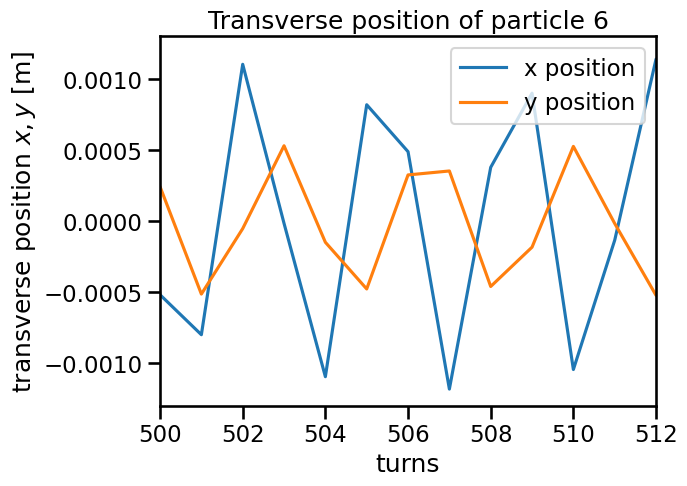

In [104]:
# Plot the position of particle 6 in the bunch over the turns
plt.plot(x_rec[:, 6], label='x position')
plt.plot(y_rec[:, 6], label='y position')
plt.legend()
plt.xlim(500, 512)
plt.xlabel('turns')
plt.ylabel('transverse position $x,y$ [m]')
plt.title('Transverse position of particle 6')
plt.show()

Incoherent tune spectra show only the bare machine tune peak

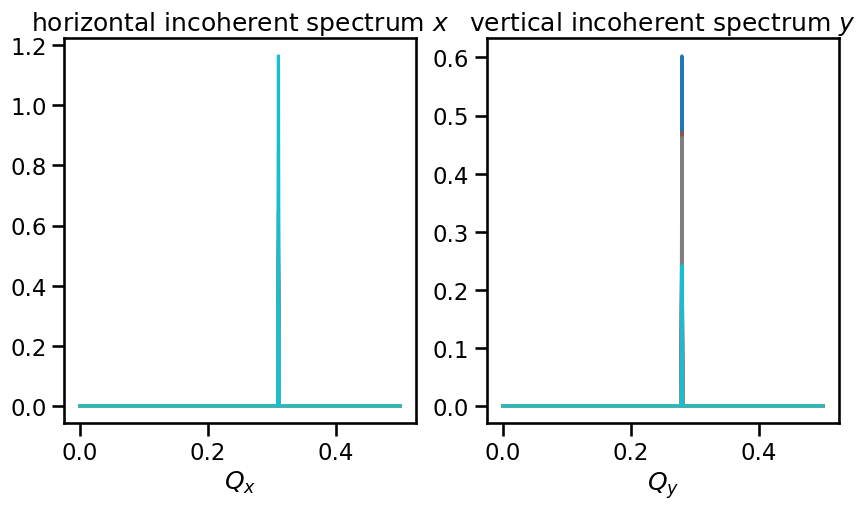

In [105]:
freqs = np.fft.rfftfreq(nturns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for x, y in zip(x_rec.T[:20], y_rec.T[:20]):
    ax[0].plot(freqs, np.abs(np.fft.rfft(x)))
    ax[1].plot(freqs, np.abs(np.fft.rfft(y)))
ax[0].set_title('horizontal incoherent spectrum $x$')
ax[0].set_xlabel('$Q_x$')
ax[1].set_title('vertical incoherent spectrum $y$')
ax[1].set_xlabel('$Q_y$')
plt.show()

## Wake Fields
Set up the slicer and wake fields to consider impedance effects on the particle bunch.

In [106]:
from PyHEADTAIL.particles.slicing import UniformBinSlicer
from PyHEADTAIL.impedances.wakes import CircularResistiveWall, CircularResonator, WakeField

# A method of longitudinal binning for the particle distrubution
# It splits the bunch into 60 slices within the z_cuts range
slicer = UniformBinSlicer(60, z_cuts=(-.1, .1))

# Set up the wake fields that affect the beam particles during the simulation
wakes = []
wake = CircularResonator(R_shunt=10e6, frequency=1e9, Q=2) # Resonator impedance that can cause coherent beam oscillations
# Parameters of the shunt impedance, resonant frequency and quality factor of the resonator are given
wakes.append(wake.function_transverse(1)) # The .function_transverse(1) calculates the wake function at a distance of 1m from the wake source
wake = CircularResistiveWall(pipe_radius=5e-2, resistive_wall_length=C*.9, conductivity=3e9, dt_min=1e-3/c, beta=bunch.beta) # Represents resistive wall impedance that can cause incoherent effects like beam energy loss
# Parameters of the pipe radius, resistive wall length, conductivity, minimum time step and beta function are given
wakes.append(wake.function_transverse(1))
# The wake fields are added to the list of wakes.

# Create a wakefield object to represent the collective effect of the wake fields on the bunch
wakefields = WakeField(slicer, wake)

# Get the longitduinal slices of the bunch using the slicer
slices = bunch.get_slices(slicer) 

Plot the wakes

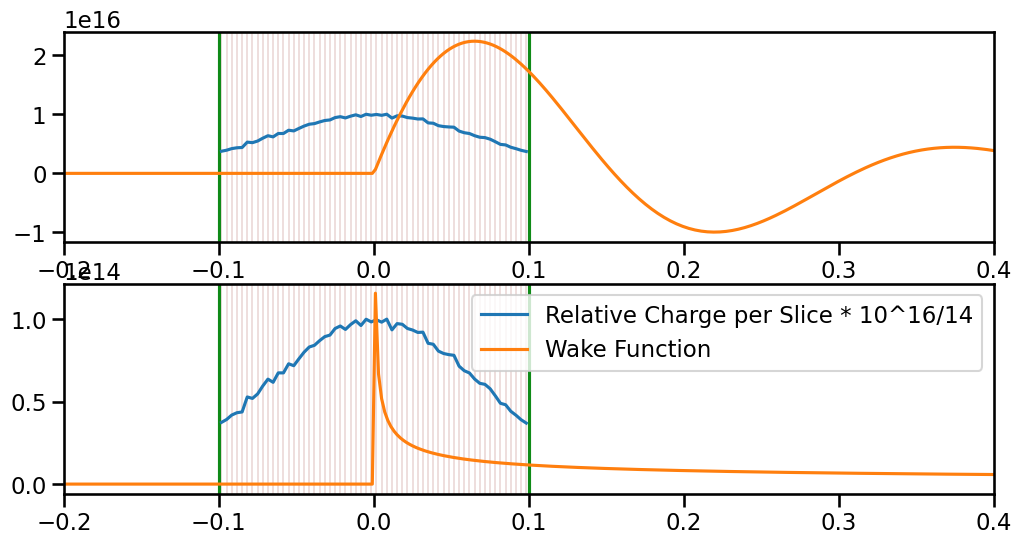

In [107]:
# List of colours to use for plotting & create subplots
col = sns.hls_palette(6, l=.3, s=.8)
fig, axes = plt.subplots(2, figsize=(12,6))

# Plot the bunch charge per slice
zz = slices.z_centers # Longitudinal positions of the centres of the slices
tt = zz/(bunch.beta*c) # Array of normalised longitudinal positions, representing z-positions divided by the product of the bunch beta and the speed of light
t0 = np.concatenate((tt-tt[-1], (tt-tt[0])[1:])) # Not sure - why is it redefined below?
t0 = np.linspace(-1, 1, 1000)/(bunch.beta*c) # Normalised longitduinal positions


for i, wk in enumerate(wakes):
    [axes[i].axvline(s, c=col[0], linewidth=0.2) for s in zz] #
    [axes[i].axvline(s, c=col[2]) for s in [slices.z_cut_tail, slices.z_cut_head]]
    axes[i].plot(zz, slices.charge_per_slice*10**[16,14][i] / max(slices.charge_per_slice), '-', label='Relative Charge per Slice * 10^16/14')
    axes[i].plot(t0 * bunch.beta * c, -wk(t0, beta=bunch.beta)[::-1], '-', label = 'Wake Function')
    axes[i].set_xlim(-.2, 0.4)

plt.legend()
plt.show()

Track particles with the wake fields

In [108]:
one_turn_map = [m for m in trans_map] + [long_map] + [wakefields]

In [109]:
plt.close('all')
plt.ion()
fig, axes = plt.subplots(3, figsize=(16, 10))

nturns = 800
turns = np.arange(nturns)
mean_z = 0.*turns
mean_dp = 0.*turns
sigma_z = 0.*turns
epsn_z = 0.*turns
for i in range(nturns):
    for m in one_turn_map:
        m.track(bunch)

    # We store the values of the tracked bunch for each turn
    mean_z[i] = bunch.mean_z()
    mean_dp[i] = bunch.mean_dp()
    sigma_z[i] = bunch.sigma_z()
    epsn_z[i] = bunch.epsn_z()
    x_rec[i, :] = bunch.x
    y_rec[i, :] = bunch.y
    z_rec[i, :] = bunch.z


    # We plot the results every 10 turns
    '''
    %matplotlib tk
    if i%10==0:
        axes[0].plot(bunch.x[::10], bunch.xp[::10]*100, '.')
        axes[1].plot(bunch.y[::10], bunch.yp[::10]*100, '.')
        axes[2].plot(bunch.z[::10], bunch.dp[::10]*1000, '.')
        axes[0].set_xlim(-4e-2, 4e-2)
        axes[0].set_ylim(-4e-2, 4e-2)
        axes[1].set_xlim(-4e-2, 4e-2)
        axes[1].set_ylim(-4e-2, 4e-2)
        axes[2].set_xlim(-0.6, 0.6)
        axes[2].set_ylim(-0.6, 0.6)
        plt.pause(0.1)
        plt.draw()
        [ax.cla() for ax in axes]
    '''

plt.ioff()
plt.close('all')

#### Plotting the Beam
Visualize the bunch distribution in the longitudinal phase space (z vs. δ) and color-codes the points based on the value of the Hamiltonian (hh) calculated for each particle in the bunch.

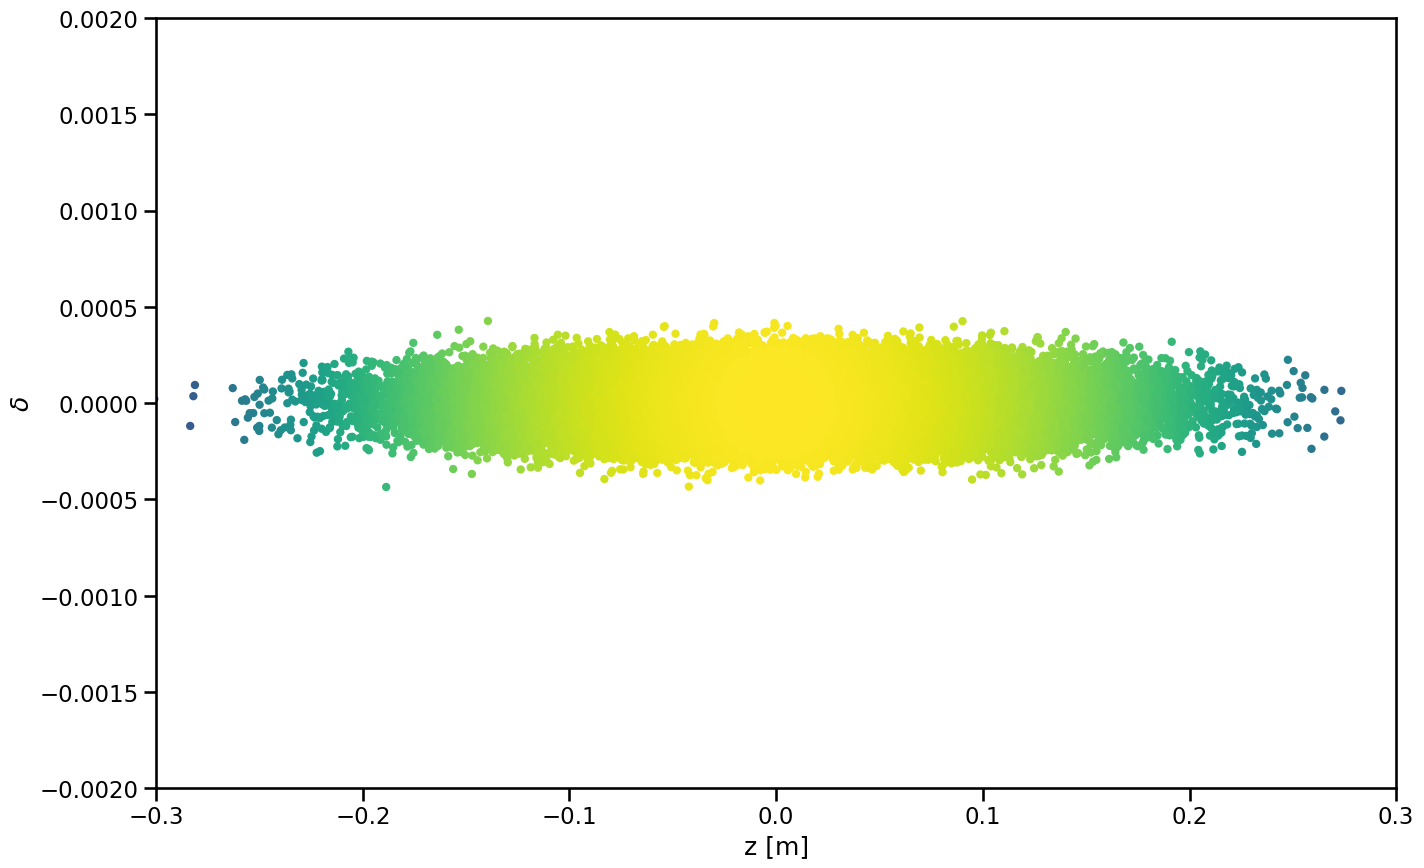

In [110]:
fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
zz = np.linspace(-.8, .8, 1000)
hh = bunch.z**2 + (100*bunch.dp)**2
#hh = rfbucket.hamiltonian(bunch.z, bunch.dp)
#ss = rfbucket.separatrix(zz)

#ax1.plot(zz, +ss, c='orange', lw=2)
#ax1.plot(zz, -ss, c='orange', lw=2)
ax1.scatter(bunch.z, bunch.dp, c=hh, marker='.', cmap=plt.cm.viridis_r)
ax1.set_xlim(-.3, .3)
ax1.set_ylim(-2e-3, 2e-3)
plt.xlabel("z [m]")
plt.ylabel(r"$\delta$")
plt.show()

Evolution of the longitudinal particle distribution

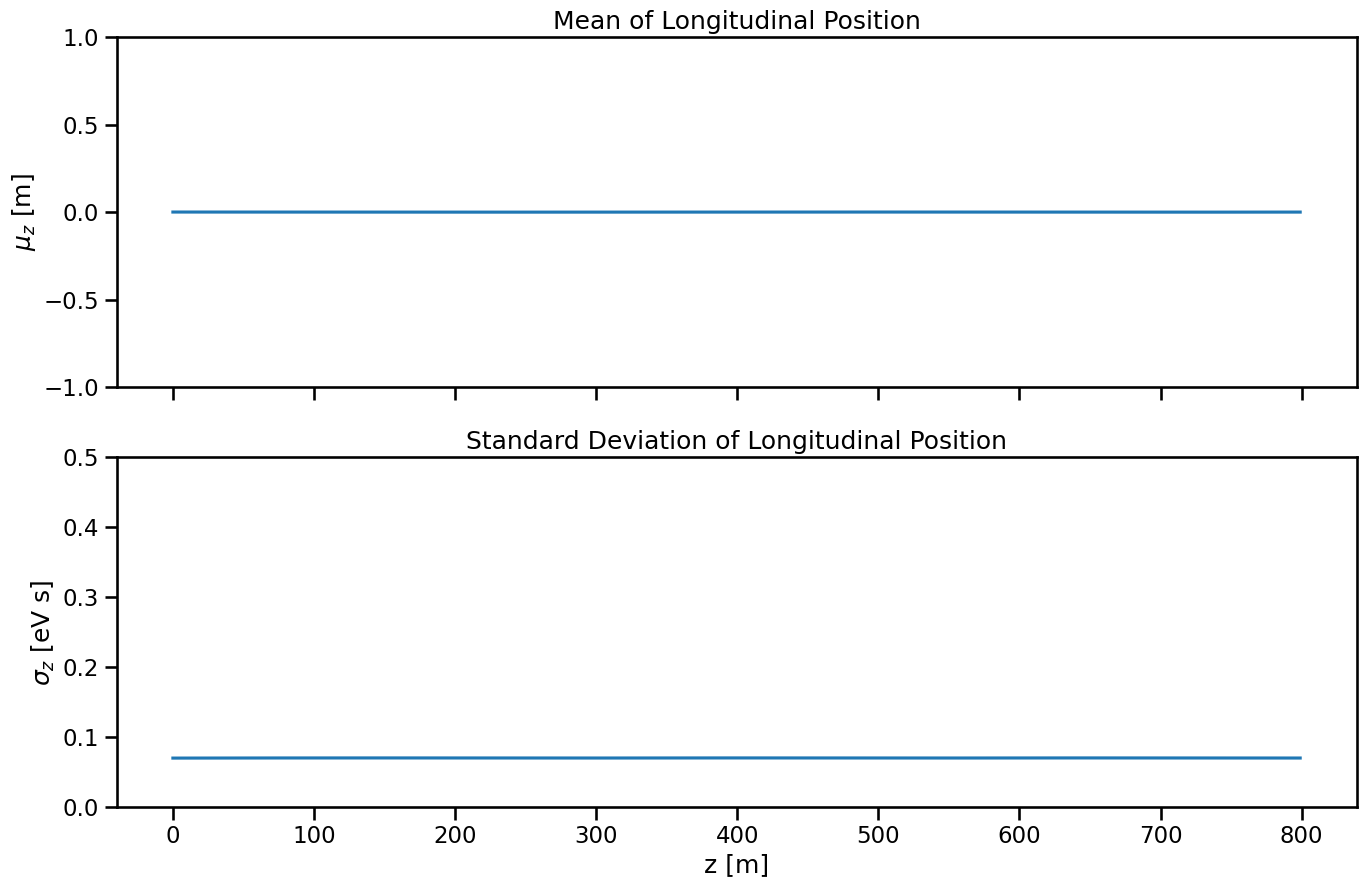

In [111]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(16,10), sharex=True)

ax1.plot(turns, mean_z)
ax1.set_ylabel(r"$\mu_z$ [m]")
ax1.set_ylim(-1, 1)
ax2.plot(turns, sigma_z)
ax2.set_xlabel("z [m]")
ax2.set_ylabel(r"$\sigma_z$ [eV s]")
ax2.set_ylim(0, 0.5)
ax1.title.set_text('Mean of Longitudinal Position')
ax2.title.set_text('Standard Deviation of Longitudinal Position')
plt.show()

#### Betatron oscillation

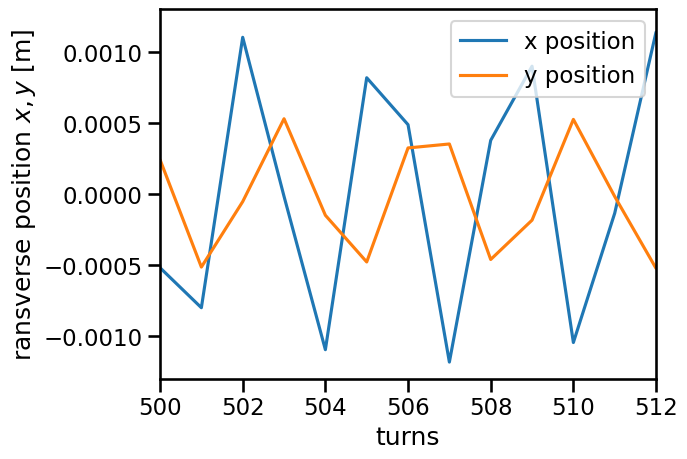

In [112]:
plt.plot(x_rec[:, 6], label='x position')
plt.plot(y_rec[:, 6], label='y position')
plt.legend()
plt.xlim(500, 512)
plt.xlabel('turns')
plt.ylabel('ransverse position $x,y$ [m]')
plt.show()

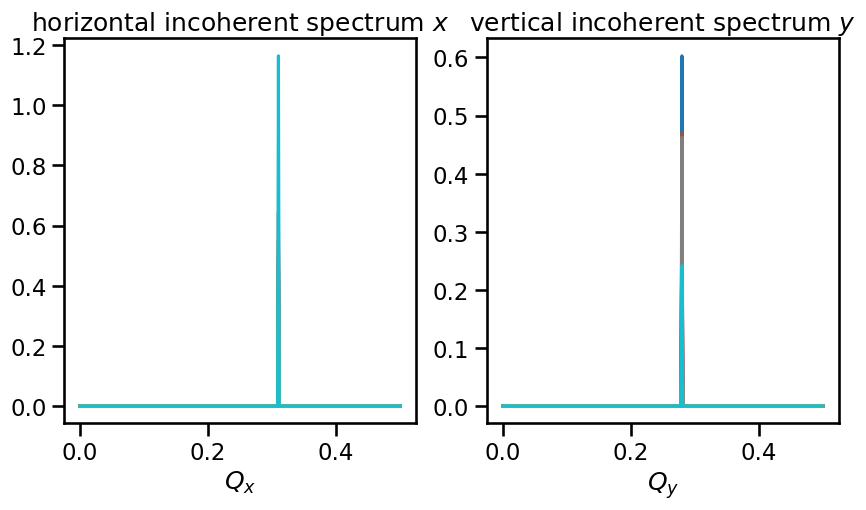

In [113]:
freqs = np.fft.rfftfreq(nturns)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
for x, y in zip(x_rec.T[:20], y_rec.T[:20]):
    ax[0].plot(freqs, np.abs(np.fft.rfft(x)))
    ax[1].plot(freqs, np.abs(np.fft.rfft(y)))
ax[0].set_title('horizontal incoherent spectrum $x$')
ax[0].set_xlabel('$Q_x$')
ax[1].set_title('vertical incoherent spectrum $y$')
ax[1].set_xlabel('$Q_y$');
plt.show()

## Longitudinal Tune Shifts

We plot the longitudinal spectrum with the wake fields but without any rf systems:

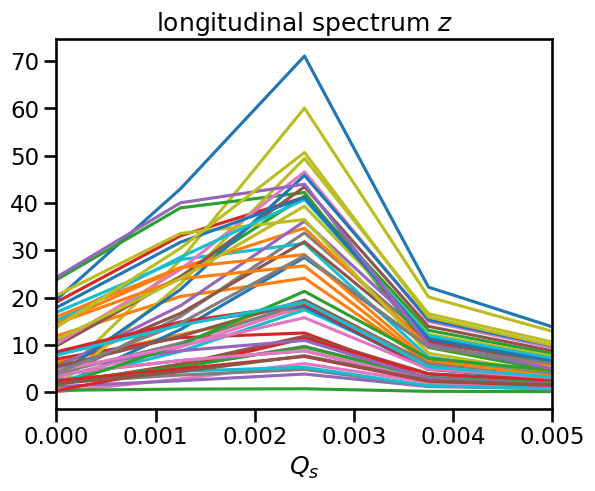

In [114]:
freqs = np.fft.rfftfreq(nturns)
for z in z_rec.T[:50]:
    plt.plot(freqs, np.abs(np.fft.rfft(z)))
plt.xlim(0, 0.005);
plt.title('longitudinal spectrum $z$')
#plt.axvline(rfbucket.Q_s, color='red', ls='--')
#plt.text(rfbucket.Q_s, plt.ylim()[1]*0.8, '  linear Q_s0')
plt.xlabel('$Q_s$')
plt.show()